In [4]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
########################
##    Reading data    ##
########################

process_0 = np.load('hist_data/process_0/heatmaps.npy')
process_1 = np.load('hist_data/process_1/heatmaps.npy')
process_2 = np.load('hist_data/process_2/heatmaps.npy')
process_3 = np.load('hist_data/process_3/heatmaps.npy')

print('process_0 :', process_0.shape)
print('process_1 :', process_1.shape)
print('process_2 :', process_2.shape)
print('process_3 :', process_3.shape, end='\n\n')

data = []
for p0, p1, p2, p3 in zip(process_0, process_1, process_2, process_3):
    data += [p0, p1, p2, p3]

data = np.array(data)
print('data :', data.shape)

process_0 : (6299, 50, 20)
process_1 : (6298, 50, 20)
process_2 : (6298, 50, 20)
process_3 : (6298, 50, 20)

data : (25192, 50, 20)


<IPython.core.display.Javascript object>


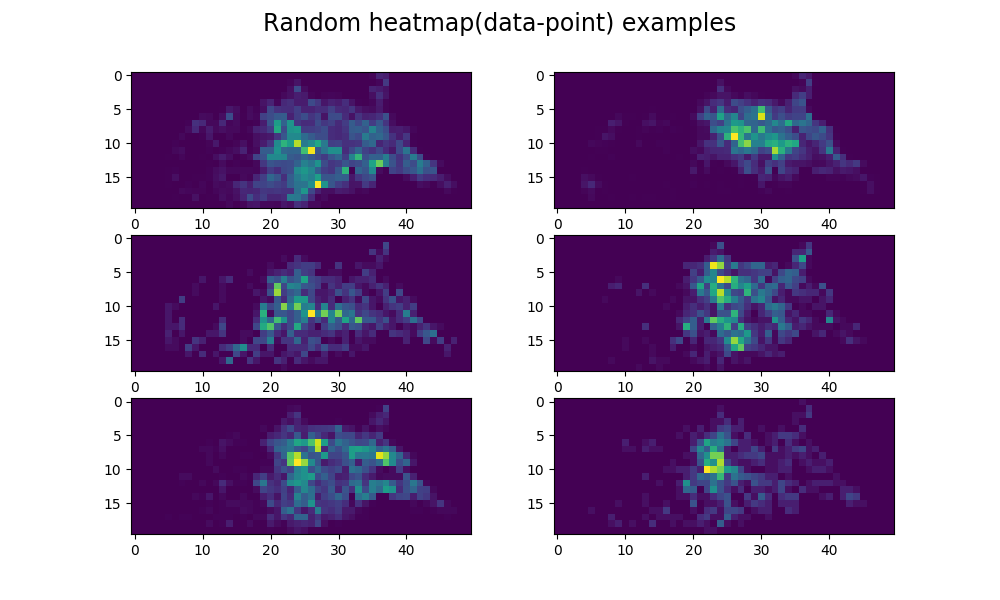

In [14]:
#####################################
##    Some random data examples    ##
#####################################

fig, axes = plt.subplots(3, 2, figsize=(10, 6))
fig.suptitle('Random heatmap(data-point) examples', fontsize=17)
axes[0, 0].imshow(data[np.random.randint(0, data.shape[0])].T)
axes[0, 1].imshow(data[np.random.randint(0, data.shape[0])].T)
axes[1, 0].imshow(data[np.random.randint(0, data.shape[0])].T)
axes[1, 1].imshow(data[np.random.randint(0, data.shape[0])].T)
axes[2, 0].imshow(data[np.random.randint(0, data.shape[0])].T)
axes[2, 1].imshow(data[np.random.randint(0, data.shape[0])].T)
plt.show()

# Train Test Split
<br>
It is important here to split the data in such a way that our train and test datasets will not contain any amount of common time zone. This way we provide that there is valid train and test datasets and all the scores we will get will be correct as well.
<br> <br>

In [15]:
############################
##    Train-Test Split    ##
############################

train_data = data[:4*data.shape[0]//5]
test_data = data[4*data.shape[0]//5:]

train_data = train_data[:,:,:,np.newaxis]
test_data = test_data[:,:,:,np.newaxis]

print('train_data  :', train_data.shape)
print('test_data   :', test_data.shape)

train_data  : (20153, 50, 20, 1)
test_data   : (5039, 50, 20, 1)


# Model
<br>
The model is Convolutional Neural Network, U-Net architecture. The input is an image and the output is alos an image of the same size and shape. It works best in such cases.

In [16]:
#################
##    Model    ##
#################

input_img = keras.layers.Input(shape=data[0][:,:,np.newaxis].shape)
logit_1 = keras.layers.Conv2D(filters=4, kernel_size=(3, 3), activation='relu', padding='same')(input_img)
logit = keras.layers.MaxPool2D(padding='valid')(logit_1)
logit_2 = keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 1), activation='relu')(logit)
logit = keras.layers.MaxPool2D(padding='valid')(logit_2)
logit_3 = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(logit)
logit_4 = keras.layers.MaxPool2D(padding='valid')(logit_3)

logit = keras.layers.Flatten()(logit_4)
logit = keras.layers.Dense(16, activation='tanh')(logit)
logit = keras.layers.Dense(16, activation='tanh')(logit)
logit = keras.layers.Dense(32, activation='tanh')(logit)

logit = keras.layers.Reshape((2, 1, 16))(logit)

logit = keras.layers.Concatenate()([logit, logit_4])
logit = keras.layers.UpSampling2D()(logit)
logit = keras.layers.Concatenate()([logit, logit_3])
logit = keras.layers.Conv2DTranspose(filters=8, kernel_size=(3, 3), activation='relu')(logit)
logit = keras.layers.UpSampling2D()(logit)
logit = keras.layers.Concatenate()([logit, logit_2])
logit = keras.layers.Conv2DTranspose(filters=4,kernel_size=(3,3),strides=(2,1),activation='relu')(logit)
logit = keras.layers.UpSampling2D()(logit)
logit = keras.layers.Concatenate()([logit, logit_1])
logit = keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), activation='relu', padding='same')(logit)

model = keras.models.Model(inputs=input_img, outputs=logit)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 20, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 20, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 25, 10, 4)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 12, 8, 8)     296         max_pooling2d_1[0][0]            
_____________________________________

In [17]:
##########################################
##   Compiling the model with L1 loss   ##
##########################################

model.compile(loss='mae', optimizer=keras.optimizers.Adam(lr=0.001))

    We can change the "epochs" parameter below and run it again, 
    it will save the current model and continue training on it.
   
    NB: 1 epoch is 1 iteration and training over the train data

In [19]:
############################
##   Training the model   ##
############################

model.fit(x=train_data[:-3*60], 
          y=np.roll(train_data, -3*60)[:-3*60],
          epochs=10,
          batch_size=32,
          validation_data=(test_data[:-3*60], 
                           np.roll(test_data, -3*60)[:-3*60]))

Train on 19973 samples, validate on 4859 samples
Epoch 1/10
19973/19973 [==============================] - 48s 2ms/step - loss: 1.7180 - val_loss: 8.7417
Epoch 2/10
19973/19973 [==============================] - 31s 2ms/step - loss: 1.6572 - val_loss: 8.6265
Epoch 3/10
19973/19973 [==============================] - 31s 2ms/step - loss: 1.6206 - val_loss: 8.5934
Epoch 4/10
19973/19973 [==============================] - 31s 2ms/step - loss: 1.5988 - val_loss: 8.5866
Epoch 5/10
19973/19973 [==============================] - 31s 2ms/step - loss: 1.5922 - val_loss: 8.4936
Epoch 6/10
19973/19973 [==============================] - 31s 2ms/step - loss: 1.5689 - val_loss: 8.5965
Epoch 7/10
19973/19973 [==============================] - 30s 2ms/step - loss: 1.5630 - val_loss: 8.5394
Epoch 8/10
19973/19973 [==============================] - 31s 2ms/step - loss: 1.5464 - val_loss: 8.5166
Epoch 9/10
19973/19973 [==============================] - 32s 2ms/step - loss: 1.5481 - val_loss: 8.5519
Epoch 

In [20]:
###################################
##   Saving the resulted model   ##
###################################

model.save('model.h5')